# Overlap in Lexical and Literary Vocabulary

Comparing the vocabulary of Old Babylonian lexical texts (from Nippur) and the vocabulary of the Sumerian literary corpus as represented in [ETCSL](http://etcsl.orinst.ox.ac.uk/).

## 0 Preparation 
In order to run this notebook, parse the [DCCLT](http://oracc.org/dcclt) data with the Extended ORACC Parser (2.1.3) and the [ETCSL](http://etcsl.orinst.ox.ac.uk) data with the ETCSL Parser (2.2).

In [2]:
%matplotlib inline
import pandas as pd
import os
from sklearn.feature_extraction.text import CountVectorizer
from matplotlib import pyplot as plt
from matplotlib_venn import venn2
import tqdm
import re
import zipfile
import json
from nltk.tokenize import MWETokenizer

### 0.1 Read ETCSL Data Files
Open the file `alltexts.csv` which contains all the [ETCSL](http://etcsl.orinst.ox.ac.uk) and read the data into a `Pandas`DataFrame. Each row is a word from [ETCSL](http://etcsl.orinst.ox.ac.uk/) in lemmatized format, according to [ePSD2](http://build-oracc.museum.upenn.edu/epsd2) standards. Only Sumerian words are kept; Akkadian glosses, for instance, are removed.

In [3]:
file = "../2_2_Data_Acquisition_ETCSL/Output/alltexts.csv"
etcsl = pd.read_csv(file, keep_default_na=False)
etcsl = etcsl.loc[etcsl["lang"].str.contains("sux")]  # throw out non-Sumerian words

### 0.2 Lemmas
Create a lemmas column and lowercase all lemmas.

The `lemmas` column is created by combining Citation Form (`cf`), Guide Word (`gw`) and Part of Speech (`pos`). The Pandas `apply()` function applies a function to every row (`axis = 1`) or column (`axis = 0`) of a dataframe. The function is defined here as a so-called `lambda` function (a temporary function). It is a simple addition of the strings of the `cf`, `gw`, and `pos` columns (with `[` and `]` as separators), so that a single lemma now looks like `lugal[king]N`. The `lambda` function has one condition: if there is no Citation Form (column `cf` equals the empty string) the contents of the column `form` are taken, followed by `NA]NA]`. The absence of a Citation Form implies that the word was not lemmatized (perhaps an unknown or a broken word). The field `form` contains the raw transliteration - the result may be `x-ra-bi[NA]NA`.

If the field `form` is empty (which happens, for instance, where a horizontal in the text is noted), however, this results in the `lemma` entry `NA[NA]`. In those case the value of `lemma` is turned into the empty string with a conditional list comprehension.

For the current analysis we will use *lemmatized* forms for the comparison between literary and lexical vocabulary. The unlemmatized forms, therefore, are of little importance here. We need to keep them, for now, because we will also compare *sequences* of lemmas. Premature removal of unlemmatized forms would result in false positives. 

In [4]:
etcsl["lemma"] = etcsl.apply(lambda r: (r["cf"] + '[' + r["gw"] + ']' + r["pos"]) 
                            if r["cf"] != '' else r['form'] + '[NA]NA', axis=1)
etcsl['lemma'] = [lemma if not lemma == '[NA]NA' else '' for lemma in etcsl['lemma'] ] 
# kick out empty forms
etcsl["lemma"] = etcsl["lemma"].str.lower()

### 0.3 Read Lexical Data

Essentially following the same process as in the preceding cells. The code assumes that the [DCCLT](http://oracc.org/dcclt) data are parsed with the Extended ORACC Parser (2.1.3) and that the resulting file is called `parsed.csv` in the directory `2_1_DataAcquisition_ORACC/output`. If this is not the case, please adjust the file name in code below.

In [5]:
file = "../2_1_Data_Acquisition_ORACC/output/parsed.csv"
lexical = pd.read_csv(file, keep_default_na=False)
lexical = lexical.loc[lexical["lang"].str.contains("sux")]

In [6]:
lexical["lemma"] = lexical.apply(lambda r: (r["cf"] + '[' + r["gw"] + ']' + r["pos"]) 
                            if r["cf"] != '' else r['form'] + '[NA]NA', axis=1)
lexical['lemma'] = [lemma if not lemma == '[NA]NA' else '' for lemma in lexical['lemma'] ] 
# kick out empty forms
lexical["lemma"] = lexical["lemma"].str.lower()

Sign lists (which belong to the broader category of lexical lists) list cuneiform signs with pronunciation glosses and sometimes with Akkadian translation, sign name, and other information. For the current purposes we *only* need the Sumerian word that is represented by the entry. We remove lemmas that derive from the pronunciation glosses and the signs themselves. Sign names and Akkadian translations are already removed, because we have selected on Sumerian only in the previous cell..

The Pandas function `isin()` compares the contents of a field with a list and returns a boolean (`True` or `False`). In this case the column `field` (which is primarily used for sign lists) is compared to the list `["sg", "pr"]`. If `field` equals one of these terms `isin()` returns `True`. The `~` before the entire expression changes `True` into `False` and vv. As a result the dataframe `lexical` now omits all rows that have either "sg" or "pr" in the column `field`.

In [7]:
lexical = lexical[~lexical["field"].isin(["sg", "pr"])] # remove lemmas that derive from the fields "sign" 
# or "pronunciation" in sign lists.

### 0.4 Select Old Babylonian Texts
The great majority of texts in [ETCSL](http://etcsl.orinst.ox.ac.uk) is from the Old Babylonian period. We will use the [DCCLT](http://oracc.org/dcclt) catalog to select only those lexcial texts that come from that same period.

The catalog is included as a separate `json` file in `dcclt.zip`. Since we parsed the [DCCLT](http://oracc.org/dcclt) text editions in preparation for this script, the file `dcclt.zip` should still be in `jsonzip` directory (if not, run the Extended ORACC Parser (2.3.3) up to the point where the ZIP file is downloaded and saved).

The file `catalogue.json` is much more shallow in structure than the text files - there is no need to parse this file. We unzip the file with the `zipfile` module, and read the `catalogue.json` file with `read` command (from the `zipfile` library) as a string into the variable `st`. We can than use the `loads()` (load string) command from the `json` package to structure the data in proper `json` format. Once loaded, the data can be read immediately into a Pandas dataframe. In order to get the dataframe properly oriented (each row representing a text) the dataframe needs to be transposed, by adding `.T` to the end of the command.

Finally the dataframe is reduced to just two columns: `id_text` and `period` so that we can select the ones that have "Old Babylonian" in the `period` column.

In [8]:
file = "../2_1_Data_Acquisition_ORACC/jsonzip/dcclt.zip"
z = zipfile.ZipFile(file) 
st = z.read("dcclt/catalogue.json").decode("utf-8")
j = json.loads(st)
cat_df = pd.DataFrame(j["members"]).T
cat_df = cat_df[["id_text", "period"]]

In [9]:
ob = cat_df[cat_df["period"] == "Old Babylonian"]
ob[:10]

,id_text,period
P117394,P117394,Old Babylonian
P117395,P117395,Old Babylonian
P117396,P117396,Old Babylonian
P117397,P117397,Old Babylonian
P117404,P117404,Old Babylonian
P128345,P128345,Old Babylonian
P142806,P142806,Old Babylonian
P145550,P145550,Old Babylonian
P209775,P209775,Old Babylonian
P209812,P209812,Old Babylonian


The index of the resulting dataframe `ob` is identical to the column `id_text` (the P, Q, or X number of each text). We can retrieve the index with the Pandas command `index.values`, which returns a list. These are the P/Q/X numbers that we want to keep.

In the dataframe `lexical` all text IDs are preceded by `dcclt/`. We can use a list comprehension to add this prefix to each entry in the `keep` list and then use this list to select only the Old Babylonian lexical texts.

In [10]:
keep = ob.index.values
keep = ['dcclt/' + id_text for id_text in keep]
lexical = lexical.loc[lexical["id_text"].isin(keep)]

## 1 First Approximation
Now we have two dataframes: `etcsl` and `lexical`. In both the field `lemma` contains the lemmatization data of a single word. We can extract the unique lemmas with the `set()` command (a set is an unordered collection of unique elements). We remove the non-elemmatized words (those have `na` as Guide Word and `na` as POS) with a set comprehension. Now we can compare the two sets in a Venn diagram.

In [11]:
etcsl_words_s = set(etcsl["lemma"])
lexical_words_s = set(lexical["lemma"])
etcsl_words_s = {lemma for lemma in etcsl_words_s if not '[na]na' in lemma}
lexical_words_s = {lemma for lemma in lexical_words_s if not '[na]na' in lemma}

The `venn2` command from the `matplotlib_venn` library creates a Venn diagram of two sets. Each set is represented by a circle, the diameter of the circle is related to the number of elements in the set. The overlap between the circles represents elements that are contained in both sets.

In its most basic form the `venn2()` command simply takes a list that contains the two sets.

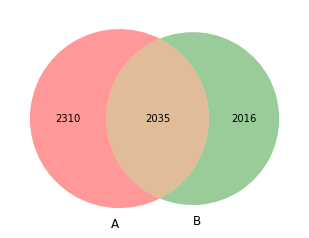

In [12]:
venn2([etcsl_words_s, lexical_words_s])

This basic plot is not too informative because it does not include the size of each set, nor its name. We can customize colors, size of the plot, and the legends. This customization is put in a function so it can be reused later on.

In [13]:
def plot_venn(lit_vocab, lex_vocab):
    """The function takes two sets and draws a Venn diagram that shows the intersection between the two sets.
    The legend includes the size of each set and the percentage of the intersection with the other set.
    """
    plt.figure(figsize=(8,8))
    lit_abs = len(lit_vocab)
    lex_abs = len(lex_vocab)
    inter_abs = len(lit_vocab.intersection(lex_vocab))
    lit_per = "{:.0%}".format(inter_abs/lit_abs)
    lex_per = "{:.0%}".format(inter_abs/lex_abs)
    lit_legend = "literary (" + str(lit_abs) + ') ' + lit_per + " overlap"
    lex_legend = "lexical (" + str(lex_abs) + ') ' + lex_per + " overlap"
    c = venn2([lit_vocab, lex_vocab], (lit_legend, lex_legend))
    c.get_patch_by_id('10').set_color("#fdb515")
    c.get_patch_by_id('01').set_color("#003262")
    c.get_patch_by_id('11').set_color("#bc9b6a")
    plt.show()
    return

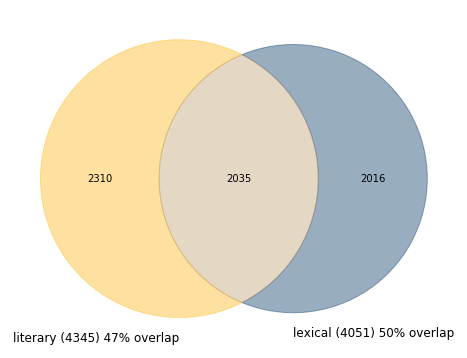

In [14]:
plot_venn(etcsl_words_s, lexical_words_s)

## 2 Second Approach: Multiple Word Expressions

Instead of looking at individual words (or lexemes), we may also look at lexical *entries* and their presence (or absence) in literary texts. The list of domestic animals, for instance, includes the entry `udu diŋir-e gu₇-a`('sheep eaten by a god'), lemmatized as `udu[sheep]n diŋir[god]n gu[eat]v/t`. Unsurprisingly, all these very common lemmas appear in the literary corpus, and thus in our previous analysis this item results in three hits. But does the expression as a whole ever appear in the literary corpus? 

In order to perform the comparison on the lexical entry level we first need to represent our data (lexical and literary) as lines, rather than as individual words. Lines in lexical texts will become our multiple word expressions. Lines in literary texts will serve as boundaries, since we do not expect our multiple word expressions to continue from one line to the next.

We will use the Multiple Word Expressions (MWE) Tokenizer from the Natural Language Toolkit (`nltk`) to identify and mark the lexical expressions in the literary corpus.

### 2.1 Line by Line

The dataframe `lexical` that was produced in section 0.4 contains the lemmatizations of all Old Babylonian lexical texts in a word-by-word (or rather lemma-by-lemma) arrangement. In order to work with lexical *entries* we need to reconstruct lines. That is, we collect the words (lemmas) that belong to the same line of the same lexical text. The dataframe `lexical` includes the fields `id_text` and `id_line` that allow us to do so. We want to change a series of entries like this:

| id_text | id_line | lemma|
|:-------|:------|:------|
| dcclt/Q000001 |	1 | udu\[sheep\]n |
| dcclt/Q000001|	1 | niga\[fattened\]v/i|
| dcclt/Q000001|	2 |	udu\[sheep\]n|
| dcclt/Q000001|	2 |	niga\[fattened\]v/i|
| dcclt/Q000001|	2 |	sag\[rare\]v/i|

Into two entries (representing two lines in a lexical text) like this:

| id_text | id_line | lemma|
|:-------|:------|:------|
| dcclt/Q000001 |	1 | (udu\[sheep\]n, niga\[fattened\]v/i) |
| dcclt/Q000001|	2 | (udu\[sheep\]n, niga\[fattened\]v/i, sag\[rare\]v/i) |

The round brackets in the `lemma` column indicate that the data format is a tuple: an immutable list. The Multiple Word Expression (MWE) tokenizer from the `nltk` package (see below) uses tuples to define MWEs, so we can directly feed the new `lemma` column into the tokenizer.

In order to do this we use the Pandas functions `groupby()` and `agg()` (for aggregate). The `groupby()` function takes as argument a list of fields on which the grouping should be performed, in this case the fields `id_text` and `id_line`. The `groupby()` function returns a so-called "GroupBy object" which preserves all the information of the original dataframe. The GroupBy object can be further manipulated with the `agg()` function.

The `agg()` function works on a GroupBy object and computes summary statistics (such as mean, sum, or average) for each group. In our case each group is a line in a lexical text and the "summary statistics" that we want is a tuple that contains all the lemmas of a single lexical line. The `agg()` function takes as argument a dictionary with field names as key and functions as value. The function `tuple` aggregates the grouped entries in the `lemma` column and and places them in a tuple. A second field that is aggregated is `extent`. This field indicates (among other things) the number of broken or illegible lines between two lines of text. We will use that data in a later phase of the analyis. The aggregation function here is `''.join`, which will simply concatenate the strings.

The `agg()` function returns a new dataframe with a composite index. The Pandas function `reset_index()` will create a new (flat) index that starts counting from 0.

In [15]:
lexical = lexical.groupby([lexical['id_text'], lexical['id_line']]).agg({
        'lemma': tuple,
        'extent': ''.join
    }).reset_index()

In [16]:
lexical[:10]

,id_text,id_line,lemma,extent
0,dcclt/P117394,2,"(kid[mat]n,)",
1,dcclt/P117394,3,"(kid[mat]n, andul[shade]n)",
2,dcclt/P117394,4,"(kid[mat]n, antadul[cloak]n)",
3,dcclt/P117395,2,"(ŋešed[key]n,)",
4,dcclt/P117395,3,"(pakud[~tree]n,)",
5,dcclt/P117395,4,"(raba[clamp]n,)",
6,dcclt/P117396,2,"(hašhur[apple]n,)",
7,dcclt/P117396,3,"(hašhur[apple]n, baza[dwarf]n)",
8,dcclt/P117396,4,"(hašhur[apple]n, mari[1]sn)",
9,dcclt/P117397,2,"(laqipu[1]dn,)",


Now we do essentially the same for the `etcsl` dataframe, reconstructing lines in literary compositions. In this case, however, we want to aggregate the `lemma` column in a list, because that is the format MWETokenizer expects for the text to be tokenized. Essentially MWETokenizer processes a text that is already tokenized, combining tokens that belong together in a Multiple Word Expression according to a list of such expressions provided by the user (in our case: the list of lexical expressions) in a tuple format.

In [17]:
etcsl = etcsl.groupby([etcsl['id_text'], etcsl['id_line'], etcsl['text_name']]).agg({
        'lemma': list,
        'extent': ''.join
    }).reset_index()

In [18]:
etcsl[1000:1010]

,id_text,id_line,text_name,lemma,extent
1000,c.1.1.3,51,Enki and the world order,"[x[na]na, x[na]na, x[na]na, en[lord]n, uŋ[peop...",
1001,c.1.1.3,52,Enki and the world order,"[aya[father]n, enki[1]dn, uŋ[people]n, numun[s...",
1002,c.1.1.3,53,Enki and the world order,"[nudimmud[1]dn, u[ewe]n, zid[right]v/i, ŋa₂[na...",
1003,c.1.1.3,54,Enki and the world order,"[ab[cow]n, numun[seed]n, e[leave]v/i, amar[you...",
1004,c.1.1.3,55,Enki and the world order,"[uzud[goat]n, zid[right]v/i, ŋa₂[na]na, e[leav...",
1005,c.1.1.3,56,Enki and the world order,"[gana[field]n, gana[field]n, zid[right]v/i, ŋa...",
1006,c.1.1.3,57,Enki and the world order,"[gurudud[heap]n, gurumaš[heap]n, aneden[steppe...",
1007,c.1.1.3,58,Enki and the world order,"[kalam[land]n, ki[place]n, tab[burn]v/t, e[lea...",
1008,c.1.1.3,60,Enki and the world order,"[x[na]na, x[na]na]",
1009,c.1.1.3,61,Enki and the world order,"[enki[1]dn, lugal[king]n, abzu[water]n, ni[fea...",


### 2.2 Extract lexical entries 
Each row in the resulting DataFrame `lexical` now consists of a text ID (`id_text`), a line number (`id_line`), and a tuple with the lemmas that represent a lexical *entry* (e.g. `(udu[sheep]n, diŋir[god]n, gu[eat]v/t)`). We extract the `lemma` column, remove duplicate lexical entries with the `set()` function and create a `list` (a list of tuples). 

Any entry that contains an unlemmatized word (characterized by "na" as Guide Word and "na" as Part of Speech is useless for the comparison and is deleted from the list.

In [38]:
lex = list(set(lexical["lemma"]))
for i in reversed(range(len(lex))):
    for lemma in lex[i]:
        if "[na]na" in lemma:
            del(lex[i])
            break
lex[0:10]

[('nurma[pomegranate]n', 'guz[crush]v/i'),
 ('hudadu[crevice]n',),
 ('kiri[nose]n', 'gig[sick]v/i'),
 ('sipad[shepherd]n', 'udu[sheep]n'),
 ('guza[chair]n', 'kugbabbar[silver]n', 'ŋar[place]v/t'),
 ('kiri[nose]n', 'gud[ox]n'),
 ('inim[word]n', 'zid[right]v/i'),
 ('e[house]n', 'epig[vessel]n'),
 ('dur[bond]n', 'gal[big]v/i'),
 ('anbarkar[mid-day]n', 'ŋeš[tree]n')]

## 2.3 Mark lexical entries in literary texts
The list `lex_vocab` now contains all uniquely lemmatized entries in the Old Babylonian lexical corpus as edited in [DCCLT](http://oracc.org/dcclt). This is the vocabulary that we wish to find in the literary corpus as edited in [ETCSL](http://etcsl.orinst.ox.ac.uk/).

In order to do so we must re-tokenize the literary corpus, using the Multiple Word Expressions Tokenizer from `nltk`. This tokenizer is initialized with a list of tuples, where each tuple represents a Multiple Word Expression. By default, the words that constitute a MWE are connected by underscores.

In order to do so we will first remove from lex_vocab the single-word entries (tuples with length 1). The resulting list is called `lex_mwe`. Now the tokenizer is inititalized with `lex_mwe` as its sole argument.

In [20]:
lex_mwe = [item for item in lex if len(item) > 1]
tokenizer = MWETokenizer(lex_mwe)

To illustrate how the MWETokenizer works we may try it on a single line of text, line 148 of the composition [Iddin-Dagan A](http://etcsl.orinst.ox.ac.uk/cgi-bin/etcsl.cgi?text=c.2.5.3.1&amp;display=Crit&amp;charenc=gcirc):

> 148. {udu}a-lum udu zulumḫi udu niga ŋiš mu-ni-ib-tag-ge
>
> "They sacrifice alum sheep, long-haired sheep, and fattened sheep for her."

In the `lemma` column of the `etcsl` DataFrame the line is represented as
> [aslum[sheep]n, udu[sheep]n, zulumhi[sheep]n, udu[sheep]n, niga[fattened]v/i, ŋeš[tree]n, tag[touch]v/t]

We can run this list of lemmas through the tokenizer to see what happens.

In [21]:
lemm_line = ["aslum[sheep]n", "udu[sheep]n", "zulumhi[sheep]n", "udu[sheep]n", "niga[fattened]v/i", "ŋeš[tree]n", "tag[touch]v/t"]
tokenizer.tokenize(lemm_line)

['aslum[sheep]n',
 'udu[sheep]n_zulumhi[sheep]n',
 'udu[sheep]n_niga[fattened]v/i',
 'ŋeš[tree]n_tag[touch]v/t']

The tokenizer thus found three Multiple Word Expressions in this single line and connected the lemmas of the MWEs by underscores. The line also illustrates a limitation of this approach. The [ETCSL](http://etcsl.orinst.ox.ac.uk) edition of [Iddin-Dagan A](http://etcsl.orinst.ox.ac.uk/cgi-bin/etcsl.cgi?text=c.2.5.3.1&amp;display=Crit&amp;charenc=gcirc) represents the first word of line 148 as {udu}a-lum, taking "udu" as a determinative (or semantic classifier). The edition of the list of animals in [OB Ura 3](http://oracc.org/dcclt/Q000001) in [DCCLT](http://oracc.org/dcclt), however, treats this same sign sequence as a sequence of two words: udu a-lum, lemmatized as udu\[sheep\]N aslum\[sheep\]N (line 8). Although aslum\[sheep\]N will result in a match, it will seem that the combination udu\[sheep\]N aslum\[sheep\]N does not appear in the literary corpus. Matches are only found if the words are represented in exactly the same way, and small inconsistencies in transliteration or lemmatization may mess things up.

We can now apply the MWE tokenizer on the entire data set, by re-tokenizing each list of lemmas in the `lemma` column of the `etcsl` DataFrame. The function `tokenize_sents()` (for "tokenize sentences") can be used to tokenize a list of lists where each second-order list represents a sentence (or, in our case, a line) in one go. The result of this function is again a list of lists, which is added as a new column (`lemma_mwe`) to the `etcsl` DataFrame.

The `lemma_mwe` column of the `etcsl` dataframe will now represent the [ETCSL](http://etcsl.orinst.ox.ac.uk/) data in a line-by-line presentation of lemmatizations, with underscores connecting lemmas if a corresponding sequence of lemmas exists as an Old Babylonian lexical entry.

In [39]:
etcsl["lemma_mwe"] = tokenizer.tokenize_sents(etcsl["lemma"])

Now join all the tuples in the list lex_vocab (this with underscores, so that the multiple-word entries are represented in the same way as they are in the literary corpus.

In [40]:
lex_vocab2 = ["_".join(entry) for entry in lex]

We can extract the column `lemma_mwe` from the `etcsl` DataFrame as a list of lists and flatten that list with a list comprehension. This returns a list that contains all lemmatizations of the entire [ETCSL](http://etcsl.orinst.ox.ac.uk) data set. After turning this list into a set (to remove duplicate lemmas) we can remove all the non-lemmatized words from the [ETCSL](http://etcsl.orinst.ox.ac.uk) data set with a set comprehension.

In [41]:
etcsl_words2 = [item for sublist in etcsl["lemma_mwe"] for item in sublist] 
etcsl_words_s2 = set(etcsl_words2)
etcsl_words_s2 = {lemma for lemma in etcsl_words_s2 if not '[na]na' in lemma}
lexical_words_s2 = set(lex_vocab2)

We can now reuse the function `plot_venn` that was created above.

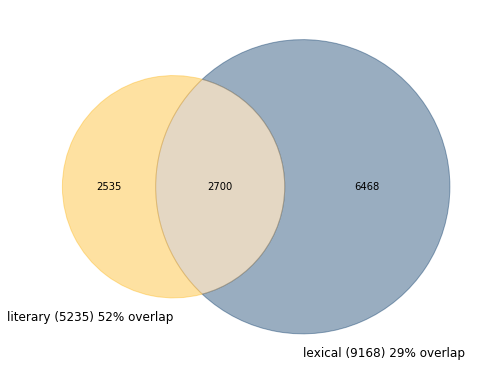

In [42]:
plot_venn(etcsl_words_s2, lexical_words_s2)

# Add them Up
### this needs a better explanation to be placed after the plot. Refer to the numbers in a more general sense, because they change whenever DCCLT changes
By creating the union of the two sets (the set with individual words and the set with the lexical entries) we get the most complete comparison of the two corpora. Here `gud[oxen]N*an[heaven]N`, `gud[oxen]N` and `an[heaven]N` are all counted as entries, whether or not `gud` and `an` actually appear as such in the lexical corpus.

In [43]:
etcsl_words_s3 = etcsl_words_s | etcsl_words_s2
lexical_words_s3 = lexical_words_s | lexical_words_s2

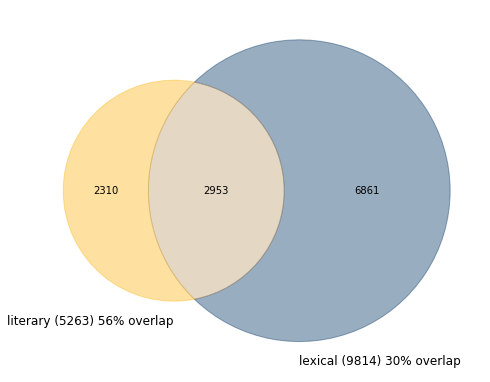

In [44]:
plot_venn(etcsl_words_s3, lexical_words_s3)

# Discussion
Whereas the change from individual *words* to *lexical expressions* made a big difference in the plot, adding the two up changes the picture only slightly. Many words (lemmas) are part of lexical entries, but are also lexical entries in and of themselves. These individual words are already included in the set of lexical entries and are taken into account in the previous plot. Nevertheless, there are several hundreds of words added on the lexical side - these are lexemes that *only* appear in multiple-word lexical entries and are not attested in the lexical corpus as separate words. 

On the literary side the number of additional entries is much smaller (counted in the tens, rather than in the hundreds). These are words that appear *only* in fixed expressions (connected by \*), but not as separate words. We can see which words those are by by subtracting the set `etcsl_words_s2` from `etcsl_words_s3`.

In [ ]:
etcsl_words_s3 - etcsl_words_s2

The word `ašgar[kid]n`, for instance, appears only once in the ETCSL corpus, in the Gudea cylinders. 

In [ ]:
etcsl[etcsl['lemma'].str.contains("ašgar\[kid\]n")]

The context is a ritual where Gudea uses a virgin female kid (`ašgar ŋeš nu-zu`). This expression appears as a whole in the Old Babylonian list of domestic animals - as a result the word `ašgar` alone was not represented in the set `etcsl_words_s2`.

For the big picture, however, the last two graphs are very similar to each other and show that on the *literary* side, a little more than half of the vocabulary is attested in (contemporary) lexical texts. On the *lexical* side, however, there appears to be a large group of words and expressions (around 70%) that were taught to students but were not used anywhere in the literary tradition.

# The End
Everything below is still in the trial and error phase.

# Digging Deeper
In order to research the relationship between lexical and literary material in more detail we first organize both corpora in a Document Term Matrix.

Both corpora are currently organized by line. The `aggregate` function assembles the lines that belong to a single composition. The resulting dataframe has 394 entries for ETCSL, one for each composition. For the lexical material we select the most important lexical compositions from Nippur in their standard format (composite texts).

In [ ]:
corpus_lit = etcsl.groupby(
    [etcsl["id_text"]]).aggregate(
    {"lemma": " ".join}).reset_index()

### 2.1 Select Lexical Compositions
Select the following compositions: 
* Ura 1 dcclt/Q000039
* Ura 2 dcclt/Q000040
* Ura 3 dcclt/Q000001
* Ura 4 dcclt/Q000041
* Ura 5 dcclt/Q000042
* Ura 6 dcclt/Q000043
* Lu₂-Azlag₂ B/C Q000302 
* Ugumu dcclt/Q000268
* Diri dcclt/Q000057
* Nigga dcclt/Q000052
* Izi dcclt/Q000050
* Kagal dcclt/Q000048
* Lu dcclt/Q000047
* Ea dcclt/Q000055

In [ ]:
keep = ["dcclt/Q000039", 
    "dcclt/Q000040",
    "dcclt/Q000001",
    "dcclt/Q000041",
    "dcclt/Q000042",
    "dcclt/Q000043",
    "dcclt/Q000302 ",
    "dcclt/Q000268",
    "dcclt/Q000057",
    "dcclt/Q000052",
    "dcclt/Q000050",
    "dcclt/Q000048",
    "dcclt/Q000047"]
lexical = lexical.loc[lexical["id_text"].isin(keep)]

In [ ]:
lexical["lemma"] = [lem.replace(' ', '*') for lem in lexical["lemma"]]
lexical

In [ ]:
corpus_lex = lexical.groupby(
    [lexical["id_text"]]).aggregate(
    {"lemma": " ".join}).reset_index()

In [ ]:
corpus_lex

corpus = pd.concat([corpus_lit, corpus_lex], ignore_index=True)
corpus

# Document Term Matrix
The corpus is transformed into a Document Term Matrix (or DTM) in which each word (or expression) is a column and each row a Sumerian composition. The lexical vocabulary is used as a filter (only words that appear in the lexical texts are allowed in the DTM).

Use CountVectorizer (from Sklearn) to initiate the DTM. The `token_pattern` indicates what a word looks like and what signals the end of a word. In modern corpora this can be fairly complex (including spaces, commas, full stops, etc.) but in the current corpus a space will always separate one token from the next. The regex `r'[^ ]+'` means "any sequence of characters, except space". Sequences of lemmas that were identified as lexical entries are connected by asterisks and are thus considered single tokens.

Transform the DTM to a dataframe.

In [ ]:
cv = CountVectorizer(analyzer='word', token_pattern=r'[^ ]+', binary = False)
dtm = cv.fit_transform(corpus['lemma'])
corpus_df = pd.DataFrame(dtm.toarray(), columns= cv.get_feature_names(), index=corpus["id_text"])

In [ ]:
corpus_df

# Remove Short Texts
Some literary texts only have a few words - either because the text is found on a very fragemnetary tablet, or because the composition is known only from a catalogue. Such short texts are likely to distoprt the analysis because every match with a lexical entry will have outsize significance. We can count the number of lemmas in a composition by adding up the numbers in a row with the command `.sum(axis=1)` (for column sums use `axis=0`).

In [ ]:
minimum = 50
corpus_df = corpus_df.loc[corpus_df.sum(axis=1) > minimum, corpus_df.sum(axis=0) > 0]
corpus_df

# Remove Unlemmatized Words

In [ ]:
lemmas = corpus_df.columns
drop = [lemma for lemma in lemmas if "[na]na" in lemma]
corpus_df = corpus_df.drop(drop, axis=1)

In [ ]:
corpus_df.shape

# Comparing
We can now start to ask questions of our DTM by comparing the vocabularies. 

In [ ]:
lit = [id for id in corpus_df.index.values if id[:5] != "dcclt"]
lit_df = corpus_df.loc[lit, :]

In [ ]:
lit_df = lit_df.loc[ : , lit_df.sum(axis=0) != 0]

In [ ]:
lit_df.shape

In [ ]:
lex = [id for id in corpus_df.index.values if id[:5] == "dcclt"]
lex_df = corpus_df.loc[lex, : ]
lex_df = lex_df.loc[ : , lex_df.sum(axis=0) != 0]
lex_df.shape

In [ ]:
lex_words = lex_df.columns
lit_words = lit_df.columns

In [ ]:
lit_in_lex = [word for word in lit_words if word in lex_words]

In [ ]:
len(lit_in_lex)

In [ ]:
lit_in_lex_df = lit_df[lit_in_lex]
lit_in_lex_df

Rare words (words that appear only once or twice) may be a strong indicator of a connection (either way) between the literary and the lexical corpus. We can reduce the dataframe to select only those rare words.

In [ ]:
rare_n = 2
rare = lit_in_lex_df.loc[ : , lit_in_lex_df.sum(axis=0) <= 2]
rare.shape

# Which literary texts share many rare words with the lexical corpus?

In [ ]:
idx = rare.sum(axis=1).sort_values(ascending=False).index
rare.loc[idx, : ]

# Retrieve composition names
Composition names are available in the original `etcsl` dataframe. Retrieve `id_text` and `text_name` from that dataframe and merge this with the dataframe `rare` by using `id_text` as index.

In [ ]:
id_name = etcsl[["id_text", "text_name"]].drop_duplicates().set_index("id_text")

In [ ]:
merged = pd.merge(rare, id_name, left_index=True, right_index=True, how='inner')
merged.loc[idx]

This shows that Ninurta's Exploits has the largest number of such rare words, shared with lexical texts. 

In [ ]:
idx = merged.sum(axis=1, numeric_only=True).sort_values(ascending = False).index
merged.loc[idx]

In [ ]:
m

# Words in Lexical Texts not in ETCSL
If a word or expression in the lexical corpus is never used in the literary texts from [ETCSL](http://etcsl.orinst.ox.ac.uk/) the sum of its column will be `0`.

Give the number of columns (the number of unique words and expressions in the lexical texts), the number of words/expressions never used in the ETCSL corpus and the relation between those two numbers in percent.

In [ ]:
lex_not_in_etcsl = etcsl_df.loc[:, etcsl_df.sum()==0]
len(etcsl_df.columns), len(lex_not_in_etcsl.columns), str(len(lex_not_in_etcsl.columns)/len(etcsl_df.columns)*100) + "%"

# Simplify
The above may be an overly complex way of doing it.
Alternative: make a full dtm of etcsl (without a vocabulary constraint); make the etcsl vocabulary and lexical vocabulary into sets that can be subtracted from each other.

In [ ]:
cv = CountVectorizer(analyzer='word', token_pattern=r'[^ ]+', binary = False)
etcsl2_dtm = cv.fit_transform(corpus['text'])
etcsl2_df = pd.DataFrame(etcsl2_dtm.toarray(), columns= cv.get_feature_names(), index=corpus["etcsl_no"])
etcsl_vocab_s = set(etcsl2_df.columns)
lex_vocab_s = set(lex_vocab)
diff_e_l = list(etcsl_vocab_s - lex_vocab_s)
diff_l_e = list(lex_vocab_s - etcsl_vocab_s)

In [ ]:
print("number of words/expressions in ETCSL " + str(len(etcsl_vocab_s)))
print("number of words/expressions in lexical texts " + str(len(lex_vocab_s)))
print("number of words/expressions in ETCSL not in lexical " + str(len(diff_e_l)))
print("number of words/expressions in lexical not in ETCSL " + str(len(diff_l_e)))

In [ ]:
plt.figure(figsize=(4,4))
venn2([etcsl_vocab_s, lex_vocab_s], ("literary", "lexical"))
plt.show()

# Rare Words Shared by Lex and Lit
Which words appear in Lex and in Lit but appear only once in Lit? In which composition do we find such words; which words are those?

First create a dataframe (`rare`) that only has the columns that add up to `1` (word or expression appears only once in the corpus). The row totals of this dataframe indicate per composition (= row) how many such rare words they contain. These row totals are added as a separate column. The composition naes are extracted from the `corpus` dataframe created above. Finally the dataframe is sorted by the row totals.

The dataframe `rare` includes columns for each of the words that appear only once. We are showing only the columns that identify the composition and the row totals.

In [ ]:
rare =etcsl_df.loc[:, etcsl_df.sum()==1].reset_index()
rare["no. of unique lexical correspondences"] = rare.sum(axis=1)
rare["text_name"] = corpus["text_name"]
rare = rare.sort_values('no. of unique lexical correspondences', ascending = False)
rare.loc[:,["etcsl_no", "no. of unique lexical correspondences", "text_name"]]

# Which Words?
Which are the rare words that define this list of compositions? We first extract the full list of words from the column names of the daraframe `rare`. The variable `words` is a Numpy array that contains strings.

In [ ]:
words = rare.columns.values
len(words)

# The rare words in the top-ten
The first ten compositions in our list are the ones that have the most rare words shared with lexical texts. Each row, representing a composition, has columns that represent individual words. We create a `mask` (a sequence of boolean values `True` or `False`) that indicate whether or not the value in the column is 1. If the boolean is `True` the word is printed.

In [ ]:
for i in range(10):
    indexes = rare.iloc[i] == 1
    print(rare.iloc[i,-1]), print(words[indexes])

In [ ]:
lexical["text"] = lexical["text"].str.replace(" ", "*")
lexical

In [ ]:
lexical_corpus = lexical.groupby([lexical["id_text"], 
                                  lexical["text_name"]]).aggregate({"text": " ".join}).reset_index()
lexical_corpus

In [ ]:
lexical_temp = lexical[["id_text", "id_line", "lemma"]]

In [ ]:
lexical_temp[lexical_temp["id_text"]=="dcclt/Q000001"]

In [ ]:
lexical = lexical.groupby([lexical['id_text'], lexical['id_line']]).agg({
        'lemma': ' '.join,
        'extent': ''.join
    })